### 1. Importação de Bibliotecas

In [1]:
#Importação de bibliotecas

#Bibliotecas para dados e gráficos
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tabulate import tabulate

#biblioteca para tocar sons
import pygame


#Bibliotecas para exportar e importar arquivos
from joblib import dump, load

#Biblioteca utilitário de GPU
from numba import cuda

#Biblioteca do scikit-learn

from sklearn.metrics import confusion_matrix

#Biblioteca para deep learning
import tensorflow as tf
from tensorflow.keras.layers import Input, LSTM, Dense
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import Adam

pygame 2.5.0 (SDL 2.28.0, Python 3.10.11)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [2]:
#checa a GPU e limpa ela
device = cuda.get_current_device()
print(device)
device.reset()

!nvidia-smi

<CUDA device 0 'b'NVIDIA GeForce GTX 1050 Ti''>
Wed Oct  4 13:26:18 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 537.42                 Driver Version: 537.42       CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce GTX 1050 Ti   WDDM  | 00000000:02:00.0  On |                  N/A |
|  0%   44C    P0              N/A /  72W |    593MiB /  4096MiB |     10%      Default |
|                                         |                      |                  N/A |
+-------------------

#### 1.1 Caminho do *dataset*

In [3]:
#path to the dataset archive
path = '../'

### 2. Aquisição e preparação do *dataset*

In [4]:
#Frame files
x_frame_file = 'x_frames_treino_05.joblib'
x2_frame_file = 'x_frames_teste_05.joblib'


y_frame_file = 'y_frames_treino_05.joblib'
y2_frame_file = 'y_frames_teste_05.joblib'


In [5]:
x_train = load(path + 'dataset/' + x_frame_file)
y_train = load(path + 'dataset/' + y_frame_file)

x_test = load(path + 'dataset/' + x2_frame_file)
y_test = load(path + 'dataset/' + y2_frame_file)

In [6]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(17544, 1)
(17544, 1)
(8760, 1)
(8760, 1)


### 6 Criação das janelas móveis

#### 6.1 Cria janelas para classicar *outlier* do mesmo dia

In [7]:
def create_frames(serie_x, serie_y, back_window_size):
    x_frames, y_frames = [], []

    for i in range(len(serie_x) - back_window_size + 1):
        x_frames.append(serie_x[i:(i + back_window_size), 0])
        y_frames.append(serie_y[(i + back_window_size - 1):i + back_window_size, 0])

    return np.array(x_frames), np.array(y_frames)

In [8]:
x_frame_train, y_frame_train = create_frames(x_train, y_train, 168)
x_frame_test, y_frame_test = create_frames(x_test, y_test, 168)

print(x_frame_train.shape)
print(y_frame_train.shape)
print(x_frame_test.shape)
print(y_frame_test.shape)

(17377, 168)
(17377, 1)
(8593, 168)
(8593, 1)


In [9]:
#Ajuste(amostras, timesteps, features)
x_frame_train = np.expand_dims(x_frame_train, axis=2)
y_frame_train = np.expand_dims(y_frame_train, axis=2)
x_frame_test = np.expand_dims(x_frame_test, axis=2)
y_frame_test = np.expand_dims(y_frame_test, axis=2)

print(x_frame_train.shape)
print(y_frame_train.shape)
print(x_frame_test.shape)
print(y_frame_test.shape)

(17377, 168, 1)
(17377, 1, 1)
(8593, 168, 1)
(8593, 1, 1)


### 7. Treinamento do modelo

In [10]:
new_model = False

#Model file
model_file = 'model/lstm_05_43_l32_001_1.h5'

history_file = 'history/history_lstm_05_43_l32_001_1.npy'

#### 7.1 Contrução do modelo

In [11]:
#-----------------
#CRIAÇÃO DO MODELO BASEADO EM LSTM
#-----------------

# Configurações de neurônios
units_lstm1 = 64
units_lstm2 = 32
units_dense = 8

# Funções de ativação
act_func_dense = 'sigmoid'
act_func_output = 'sigmoid'

#inicializador
initializer = tf.keras.initializers.LecunNormal(seed=43)

# Criação das entradas de treino
inputs = Input(shape=(x_frame_train.shape[1], x_frame_train.shape[2]), name="input")

# Camada LSTM 1
layer_lstm1 = LSTM(units_lstm1,
                     return_sequences=True,
                     kernel_initializer=initializer,
                     name="lstm1")(inputs)

# Camada LSTM 2
layer_lstm2 = LSTM(units_lstm2,
                     return_sequences=False,
                     kernel_initializer=initializer,
                     name="lstm2")(layer_lstm1)

# Camada densa final para ajustar o formato da saída
layer_dense = Dense(units_dense,
                    activation=act_func_dense,
                    name="layer_dense")(layer_lstm2)

# Camada densa final para ajustar o formato da saída
layer_dense_out = Dense(y_frame_train.shape[1],
                        activation=act_func_output,
                        name="layer_output")(layer_dense)

# Criação do modelo
lstm_load = Model(inputs=inputs, outputs=layer_dense_out)

In [12]:
lstm_load.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 168, 1)]          0         
                                                                 
 lstm1 (LSTM)                (None, 168, 64)           16896     
                                                                 
 lstm2 (LSTM)                (None, 32)                12416     
                                                                 
 layer_dense (Dense)         (None, 8)                 264       
                                                                 
 layer_output (Dense)        (None, 1)                 9         
                                                                 
Total params: 29,585
Trainable params: 29,585
Non-trainable params: 0
_________________________________________________________________


In [13]:
if new_model:
    es = EarlyStopping(monitor='val_loss', mode='min', patience=100)

    cp = ModelCheckpoint(filepath='models/',
                            save_weights_only=True,
                            monitor='val_loss',
                            mode='min',
                            save_best_only=True)

    opt = Adam(learning_rate=0.001)

    lstm_load.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

    history = lstm_load.fit(x_frame_train,
                            y_frame_train,
                            validation_split=0.3,
                            epochs=350,
                            verbose=1,
                            callbacks=[cp, es],
                            batch_size=32,
                            shuffle=False)

    np.save(path + 'model_rnn/models/' + history_file, history.history)
    lstm_load.save_weights(path + 'model_rnn/models/')
    lstm_load.save(path + 'model_rnn/models/' + model_file)
else:
    lstm_load = load_model(path + 'model_rnn/models/' + model_file)
    history = np.load(path + 'model_rnn/models/' + history_file, allow_pickle=True)

In [14]:
#toca um som para avisar que terminou de executar
pygame.mixer.init()
arquivo_mp3 = path + 'support_files/mario_coin.mp3'
pygame.mixer.music.load(arquivo_mp3)
pygame.mixer.music.play()

while pygame.mixer.music.get_busy():
    continue
    
print('Sucesso!')

Sucesso!


In [15]:
#Descomentar se usar modelo pronto
#Retorna os dicionarios que está no array do numpy
history = history.item()
#history = history.history

#### 7.2 Análise do Modelo

In [16]:
print('Erro mínimo conj. Treino: ', min(history['loss']))
print('Erro mínimo conj. Validação: ', min(history['val_loss']))

Erro mínimo conj. Treino:  0.01647971011698246
Erro mínimo conj. Validação:  0.013447059318423271


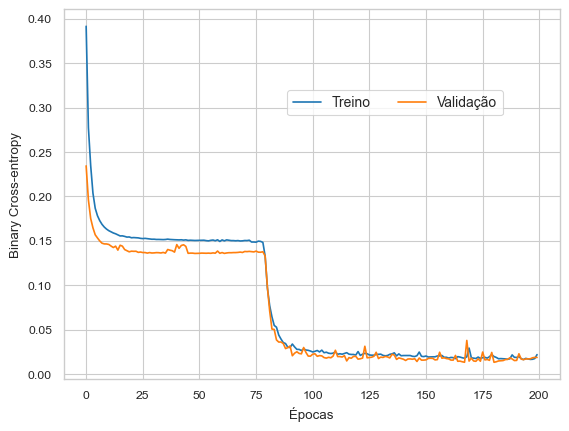

In [17]:
sns.set_style('whitegrid')
sns.set_context('paper')

train_metric = history['loss']
valid_metric = history['val_loss']
name_metric = 'Binary Cross-entropy'

fig = plt.figure()

plt.plot(train_metric, label='Treino'), 
plt.plot(valid_metric, label='Validação')
plt.ylabel(name_metric)
plt.xlabel('Épocas')


plt.legend(loc='upper right', bbox_to_anchor=(0.9, 0.8), fancybox=True, shadow=False, prop={'size': 10}, ncol=2)

plt.show()

In [18]:
y_hat = lstm_load.predict(x_frame_test)
y_hat = (y_hat > 0.5)
y_hat = np.array(y_hat, dtype=np.int8)

269/269 [==============================] - 34s 15ms/step


In [19]:
y_frame_test = np.squeeze(y_frame_test).reshape(len(y_frame_test), 1)

In [20]:
#calculando a matriz de confusao
cm = confusion_matrix(y_frame_test.tolist(), y_hat.tolist())
#calculando a taxa de acerto

accuracy = (cm[0, 0] + cm[1, 1]) / cm.sum()
accuracy_percent = round(accuracy * 100, 2)
print("Taxa de Acerto: {:.2f}%".format(accuracy_percent))

Taxa de Acerto: 99.35%


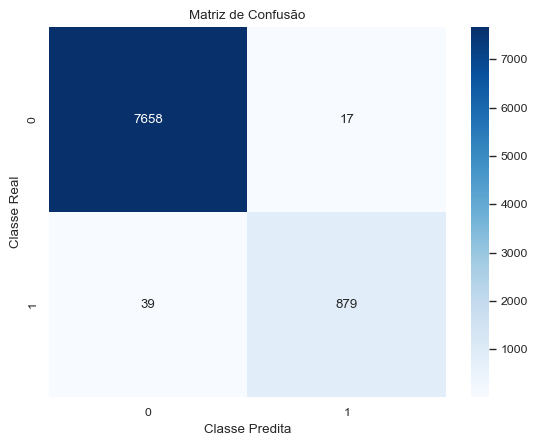

In [21]:
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Matriz de Confusão')
plt.xlabel('Classe Predita')
plt.ylabel('Classe Real')

plt.show()

In [22]:
from sklearn.metrics import precision_score, recall_score

# Calcular a precisão
precision = precision_score(y_frame_test.tolist(), y_hat.tolist())

# Calcular o recall
recall = recall_score(y_frame_test.tolist(), y_hat.tolist())

print("Precisão:", precision)
print("Recall:", recall)

Precisão: 0.9810267857142857
Recall: 0.9575163398692811


### Grafico classificação

In [23]:
def min_max_denormalization(normalized_data, min_data, max_data):
    min_val = min_data
    max_val = max_data
    denormalized_data = []

    for normalized_value in normalized_data:
        denormalized_value = (normalized_value * (max_val - min_val)) + min_val

        denormalized_data.append(denormalized_value)

    return denormalized_data

In [24]:
x_test_desnormalization = np.array(min_max_denormalization(x_test[167:], min_data=19000, max_data=55000))

#### Descobrindo indices e Limites LSTM

In [25]:
# Descobrir o Limite superior e inferior definido pela LSTM
# 1 Saber Os indices que foram classificados como outliers
indices_hat_outliers = np.where(y_hat == 1)[0]

# 2  Pegar os valores de carga dos indices de outliers
x_aux = x_test_desnormalization
x_hat_outliers = x_aux[indices_hat_outliers]

# 3 pegar o menor valor do limite superior e o maior valor do limite inferior
min_lim_sup = np.min(x_hat_outliers[x_hat_outliers > 38000])
print('Limite Superior LSTM: ', min_lim_sup)

max_lim_inf = np.max(x_hat_outliers[x_hat_outliers < 40000])
print('Limite Inferior LSTM: ', max_lim_inf)


Limite Superior LSTM:  47073.0
Limite Inferior LSTM:  30118.0


#### Descobrindo indices outliers IQR

In [26]:
indices_test_outliers = np.where(y_frame_test == 1)[0]
x_test_outliers = x_aux[indices_test_outliers]

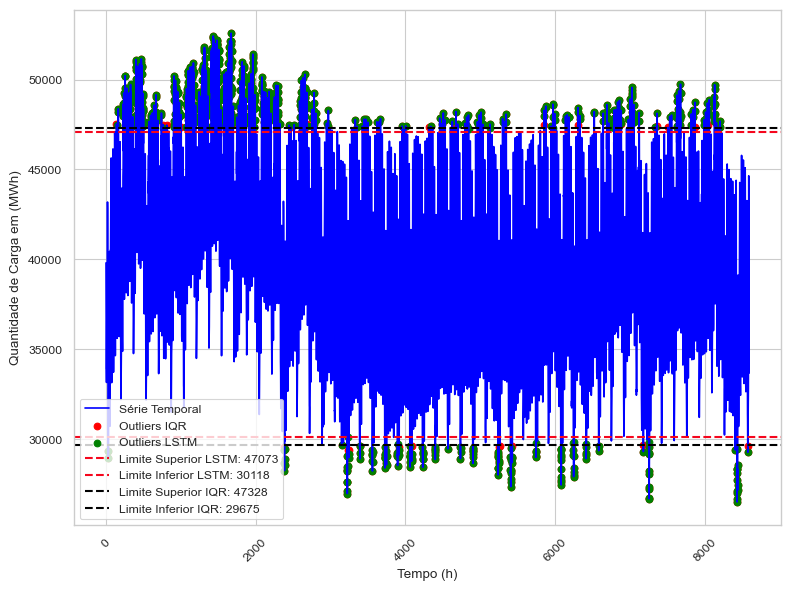

In [32]:
plt.figure(figsize=(8, 6))


plt.plot(x_test_desnormalization, color='blue', label='Série Temporal')
plt.scatter(indices_test_outliers, x_test_outliers, color='red', marker='o', label='Outliers IQR', zorder=0)
plt.scatter(indices_hat_outliers, x_hat_outliers, color='green', marker='o', label='Outliers LSTM', zorder=1)


plt.xlabel('Tempo (h)')
plt.ylabel('Quantidade de Carga em (MWh)')
plt.xticks(rotation=45)

plt.axhline(y=47073, color='#f5061d', linestyle='--', linewidth=1.5, label='Limite Superior LSTM: 47073')
plt.axhline(y=30118, color='#f5061d', linestyle='--', linewidth=1.5, label='Limite Inferior LSTM: 30118')
plt.axhline(y=47328, color='#000000', linestyle='--', linewidth=1.5, label='Limite Superior IQR: 47328')
plt.axhline(y=29675, color='#000000', linestyle='--', linewidth=1.5, label='Limite Inferior IQR: 29675')

plt.legend(loc='lower left')


plt.tight_layout()
plt.show()
